In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import cupy as cp
from cupyx.scipy import ndimage
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import random
import time
from PIL import Image
import pickle
import os
import re
from collections import Counter

In [44]:
# configs
curr_dir = os.path.abspath(os.getcwd())
save_dir = os.path.join(curr_dir, "modeling/disc_gen_outputs")
seeds = [3]#[3, 4, 7, 8, 11, 12]
niter = 1000
perturb_len = 100
epsilon = 0
window_size = 3400
pattern_dim = 40
p = 1/16
pad = 100

In [45]:
# functions

def generate_window(seed):
    np.random.seed(seed)
    start = time.time()
    random_pattern = np.random.rand(pattern_dim, pattern_dim)
    binary_pattern = np.where(random_pattern < p, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+pad
    pattern_dim_scaled = pattern_dim*200+2*pad
    
    centroids = []
    im = np.zeros((pattern_dim_scaled, pattern_dim_scaled))

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, centroids

def get_image(seed):
    im, centroids = generate_window(seed)
    while not len(centroids) > 2:
        im, centroids = generate_window(seed)
    return im, centroids

def extract_features(image, sigma, centroids):

    im_blur = ndimage.gaussian_filter(cp.array(image), sigma=sigma, mode='constant',cval=0)
    plt.imshow(im_blur.get())
    im_blur_norm=im_blur*sigma*cp.sqrt(np.pi)

    im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
    im_sobel=np.hypot(im_sx, im_sy)

    feats = []
   
    for centroid in centroids:
        x, y = centroid[0], centroid[1]
        density = cp.mean(im_blur_norm[x-75: x+75, y-75: y+75])
        grad = cp.mean(im_sobel[x-75: x+75, y-75: y+75])
        feats.append([density.get(), grad.get()])

    cp._default_memory_pool.free_all_blocks()

    feats = np.array(feats)
    return feats

def simulate(image, centers):
    test_img = image.copy()
    test_centers = centers.copy()
    
    nx, ny, ix = random_move(test_centers)
    old_x, old_y = test_centers[ix]
    test_img[old_x-75: old_x+75, old_y-75:old_y+75] = 50
    test_img[nx-75:nx+75, ny-75:ny+75] = 255
    test_centers[ix] = (nx, ny)
    
    new_score = evaluate(test_img, test_centers)
    
    return test_img, test_centers, new_score

def random_move(centers):
    found_valid_move = False
    newx, newy, random_index = 0, 0, 0
    
    while not found_valid_move:
        random_index = random.randint(0,len(centroids)-1)
        
        angle = np.pi * np.random.uniform(0, 2)
        dx, dy = perturb_len*np.cos(angle), perturb_len*np.sin(angle)
        dx, dy = np.rint(dx), np.rint(dy)
        newx, newy = int(centers[random_index][0] + dx), int(centers[random_index][1] + dy)

        nbors = centers[:random_index] + centers[random_index+1:]
        
        found_valid_move = validate(newx, newy, nbors)
    
    return newx, newy, random_index

def validate(cx, cy, centroids):   
    cxbool = out_of_bounds_check(cx)
    cybool = out_of_bounds_check(cy)
    
    rep = np.tile(np.array([cx, cy]).reshape(-1,2), [len(centroids), 1])
    centroids_arr = np.array(centroids)
    dist = np.sqrt(np.sum((rep-centroids_arr)**2, axis = 1))
    min_dist = 2*(75*np.sqrt(2)+25)
    valid = np.all(dist > min_dist)
    
    check = cxbool and cybool and valid
    
    return check

def out_of_bounds_check(coord):
    if (coord < 200) or (coord > window_size - 200):
        return False
    else:
        return True

def evaluate(im_pattern, centroids):
    new_feats = []

    for sigma in uniq_sigs:
        feats = extract_features(im_pattern, sigma, centroids)
        new_feats.append(feats[:, 0].reshape(-1,1))
        new_feats.append(feats[:, 1].reshape(-1,1))

    new_feats = [new_feats[ix] for ix in ix_sigs]
    new_feats = np.hstack(new_feats)
    preds = model.predict(new_feats)
    pred_mean = np.mean(preds)
        
    return pred_mean

def backward_elim(X_iter, y, n_feats):
    n_iter = X_iter.shape[1]
    
    while n_iter > n_feats:
        feat_ix = list(range(X_iter.shape[1]))
    
        min_ix = 0
        min_error = -np.infty
        for ix in feat_ix:
            cols = feat_ix[:ix] + feat_ix[ix+1:]
            temp_df = X_iter.iloc[:, cols]
            temp_error = cross_val_score(model, temp_df, y, cv = 5, scoring = "neg_mean_squared_error").mean()
            if temp_error > min_error:
                min_ix = ix
                min_error = temp_error

        cols = feat_ix[:min_ix] + feat_ix[min_ix+1:]
        X_iter = X_iter.iloc[:, cols]
        n_iter = X_iter.shape[1]
        
    return X_iter

In [42]:
# train discriminator
df = pd.read_csv("all_sigmas_df_comb.csv")
X, y = df.iloc[:, :-4], df.iloc[:, -1] 
model = SVR(kernel='rbf')
X_reduc = backward_elim(X, y, 3)
model = model.fit(X_reduc, y)

# get features from backward elimination
cols = X_reduc.columns.values
sigmas = [int(''.join(filter(str.isdigit, item))) for item in X_reduc.columns.values]
uniq_sigs = sorted(list(set(sigmas)))
f_density = lambda x: str(x) + "_density"
f_grad = lambda x: str(x) + "_grad"
all_feats = [f(sigma) for sigma in uniq_sigs for f in (f_density, f_grad)]
ix_sigs = [all_feats.index(col) for col in cols]

# generate small window

In [7]:
seed = 3
im, centroids  = get_image(seed)
im_init = Image.fromarray(im.astype(np.uint8))
im_init.save(os.path.join(save_dir,"init_seed_" + str(seed) + ".png"))

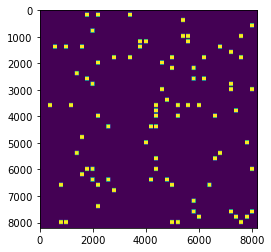

In [8]:
plt.imshow(im)

In [9]:
hi = np.lib.stride_tricks.sliding_window_view(im, (3000, 3000))

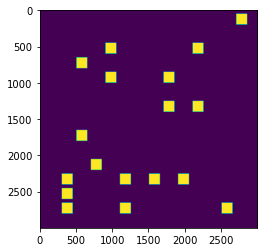

In [10]:
examp_3 = hi[1250][4000]
plt.imshow(examp_3)

In [20]:
import cv2

blurred = cv2.GaussianBlur(examp_3.astype(np.uint8), (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

centers = []
# loop over the contours
for c in cnts[0]:
    # compute the center of the contour
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centers.append((cX, cY))
    # draw the contour and center of the shape on the image

In [21]:
centers = [(x+1+200, y+1+200) for x,y in centers]
mask = np.zeros((3400, 3400))
for x, y in centers:
    mask[y-75: y+75, x-75:x+75] = 255

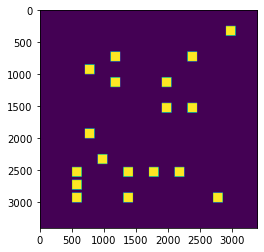

In [22]:
plt.imshow(mask)

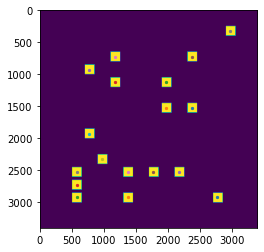

In [23]:
plt.imshow(mask)
for x,y in centers:
    plt.scatter(x,y, s = 5)
plt.show()

In [26]:
for x,y in centers:
    print(np.unique(mask[y-75:y+75, x-75:x+75]))

[255.]
[255.]
[255.]
[255.]
[255.]
[255.]
[255.]
[255.]
[255.]
[255.]
[255.]
[255.]
[255.]
[255.]
[255.]
[255.]
[255.]
[255.]


In [28]:
# CRUCIAL TO FLIP!
centers = [(y,x) for x,y in centers]

# vanilla simulated annealling on small window

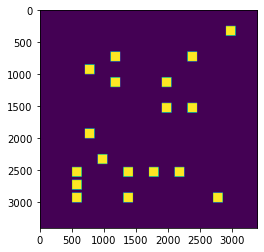

In [47]:
plt.imshow(mask)

In [187]:
mask.shape

(3400, 3400)

In [ ]:
im = mask
centroids = centers # make sure that centroids are flipped in y and x (shown above)

for seed in seeds:
    # save initial image
    #im, centroids  = get_image(seed)
    #im_init = Image.fromarray(im.astype(np.uint8))
    #im_init.save(os.path.join(save_dir,"init_seed_" + str(seed) + ".png"))

    log = []

    # run simulated annealing
    for _ in tqdm(range(niter)):
        plt.imshow(im)
        plt.show()

        curr_score = evaluate(im, centroids)

        new_im, new_centroids, new_score = simulate(im, centroids)

        log.append((curr_score, new_score, centroids))

        if new_score - curr_score > epsilon:
            print("improved")
            im, centroids, curr_score = new_im, new_centroids, new_score

    # save log and final image
    with open(os.path.join(save_dir, "log" + str(seed) + ".txt"), "wb") as fp: 
        pickle.dump(log, fp)

    im_final = Image.fromarray(im.astype(np.uint8))
    im_final.save(os.path.join(save_dir, "final_seed_" + str(seed)+ ".png"))

Text(0.5, 0, 'Iteration')

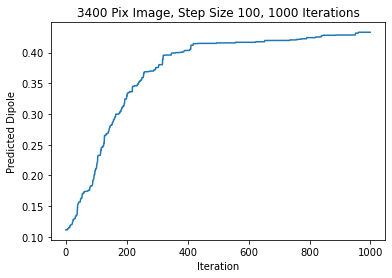

In [50]:
scores = [item[0] for item in log]
plt.plot(scores)
plt.title("3400 Pix Image, Step Size 100, 1000 Iterations")
plt.ylabel("Predicted Dipole")
plt.xlabel("Iteration")

In [58]:
log[-1]

(0.43322293250926025,
 0.4311551558005079,
 [(2797, 2356),
  (2873, 1112),
  (2925, 575),
  (2725, 575),
  (3022, 2494),
  (1208, 1142),
  (2717, 1327),
  (2500, 721),
  (2876, 835),
  (1085, 1409),
  (1446, 2198),
  (1422, 1894),
  (1152, 2025),
  (1019, 949),
  (758, 980),
  (1193, 2302),
  (837, 1232),
  (469, 2960)])

# accelerated simulated annealing

In [66]:
with open(os.path.join(save_dir, "log" + str(seed) + ".txt"), 'rb') as f:
    yerr = pickle.load(f)

In [69]:
yerr[0]

(0.11117671630832901,
 0.11115611508010846,
 [(2925, 2775),
  (2925, 1375),
  (2925, 575),
  (2725, 575),
  (2525, 2175),
  (2525, 1775),
  (2525, 1375),
  (2525, 575),
  (2325, 975),
  (1925, 775),
  (1525, 2375),
  (1525, 1975),
  (1125, 1975),
  (1125, 1175),
  (925, 775),
  (725, 2375),
  (725, 1175),
  (325, 2975)])